# ResNet

Когда более глубокая сеть начинает сворачиваться, возникает проблема: с увеличением глубины сети точность сначала увеличивается, а затем быстро ухудшается. Снижение точности обучения показывает, что не все сети легко оптимизировать.



## Shortcut Connection

![-](data/shortcut-connection.png)

Соединения быстрого доступа пропускают один или несколько слоев и выполняют сопоставление идентификаторов. Их выходы добавляются к выходам stacked layers. 

Про такие соединения есть подробный разбор в `notebooks/skewbek/SkipConnection`

## Архитектура ResNet

![-](data/architecture.jpg)

![-](data/architecture2.jpg)

Добавление быстрого соединения, которое превращает сеть в ее остаточную версию. Идентификационные быстрые соединения F(x{W}+x) могут использоваться непосредственно, когда вход и выход имеют одинаковые размерности (быстрые соединения сплошной линии на рис). Когда размерности увеличиваются (пунктирные линии на рис), он рассматривает два варианта:

- Быстрое соединение выполняет сопоставление идентификаторов с дополнительными нулями, добавленными для увеличения размерности. Эта опция не вводит никаких дополнительных параметров.

- Проекция быстрого соединения  в F(x{W}+x) используется для сопоставления размерностей (выполнено с помощью 1×1 сверток).

Такая архитектура совершила революцию в классификации изображения. Поэтому мы постараемся написать ResNet подобную модель. 

Чтобы понять какие изменения мы внесем в нашу модель, давайте выявим различия нашей задачи и задачи ResNet.

- Классов у нас 10. А в ImageNet, датасет для которого был написан resnet, имеет 1000 классов
- Наш датасет имеет размерность изображений (32, 32, 3). В ImageNet нет определенных разменостей, однако большинство картинок имеет примерно размер (500, 400, 3).

Давайте напишем модель.

In [1]:
import sys

import tensorflow as tf
import torchvision as tv
from livelossplot import PlotLossesKeras

sys.path.append('../../../')

from core.datasets import get_ds

Первый слой resnet это самая большая свертка в моделе и maxpool.

![-](data/step1.jpg)

In [2]:
inputs = tf.keras.Input(shape=(32, 32, 3), batch_size=512)
x = tf.keras.layers.Conv2D(64, 5, activation='relu', padding='same')(inputs)
block1 = tf.keras.layers.MaxPool2D(2)(x)

In [3]:
block1.shape

TensorShape([512, 16, 16, 64])

----
Далее идет первый блок сверток

- свертки размером (3, 3), кол-во фильтров 64

![-](data/step2.jpg)

In [4]:

x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(block1)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)

block2 = tf.keras.layers.add([block1, x])

x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(block2)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)

block3 = tf.keras.layers.add([block2, x])

In [5]:
block3.shape

TensorShape([512, 16, 16, 64])

---
Дальше идет уменьшее размерности изображения вдвое, в кол-во фильтров увеличивается вдвое

![-](data/step3.jpg)

In [6]:

x = tf.keras.layers.Conv2D(128, 3, strides=2, activation='relu', padding='same')(block3)
x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)

block3_conv = tf.keras.layers.Conv2D(128, 1, strides=2, activation='relu')(block3)
block4 = tf.keras.layers.add([x, block3_conv])

x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(block4)
x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)

block5 = tf.keras.layers.add([block4, x])

x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(block5)
x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)

block6 = tf.keras.layers.add([block5, x])

In [7]:
block6.shape

TensorShape([512, 8, 8, 128])

----
У нас изображения сильно меньше чем у ImageNet, поэтому добавим третий, последний, блок сверток.
Можно заметить, что в блоках, которые стоят по середине слоев больше, поэтому в последнем блоке сделаем столько же слоев, сколько и в первом.

In [8]:

x = tf.keras.layers.Conv2D(256, 3, strides=2, activation='relu', padding='same')(block6)
x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(x)

block6_conv = tf.keras.layers.Conv2D(256, 1, strides=2, activation='relu')(block6)
block7 = tf.keras.layers.add([x, block6_conv])

x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(block7)
x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(x)

block8 = tf.keras.layers.add([block7, x])

In [9]:
block8.shape

TensorShape([512, 4, 4, 256])

----
Осталось применить Global Average Pooling и добавить 10 выходных нейронов.

In [10]:
x = tf.keras.layers.GlobalAveragePooling2D()(block8)
x = tf.keras.layers.Flatten()(block8)
outputs = tf.keras.layers.Dense(10, 'softmax')(x)

In [11]:
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(512, 32, 32, 3)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (512, 32, 32, 64)    4864        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (512, 16, 16, 64)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (512, 16, 16, 64)    36928       ['max_pooling2d[0][0]']          
                                                                                              

In [12]:
jitter = tv.transforms.ColorJitter(brightness=.2, hue=0.2, contrast=0.5)
perspective = tv.transforms.RandomPerspective(distortion_scale=0.2, p=0.4)
affine = tv.transforms.RandomAffine(degrees=(-15, 15), translate=(0, 0.1), scale=(0.85, 1))
transform = tv.transforms.Compose([
    jitter,
    affine,
    perspective,
])
train_ds, val_ds, test_ds = get_ds('repaired_data_train', 'repaired_data_test', back=3, transform=transform)


In [13]:
model.compile(optimizer='adam', metrics=['accuracy'],
        loss=tf.keras.losses.SparseCategoricalCrossentropy())

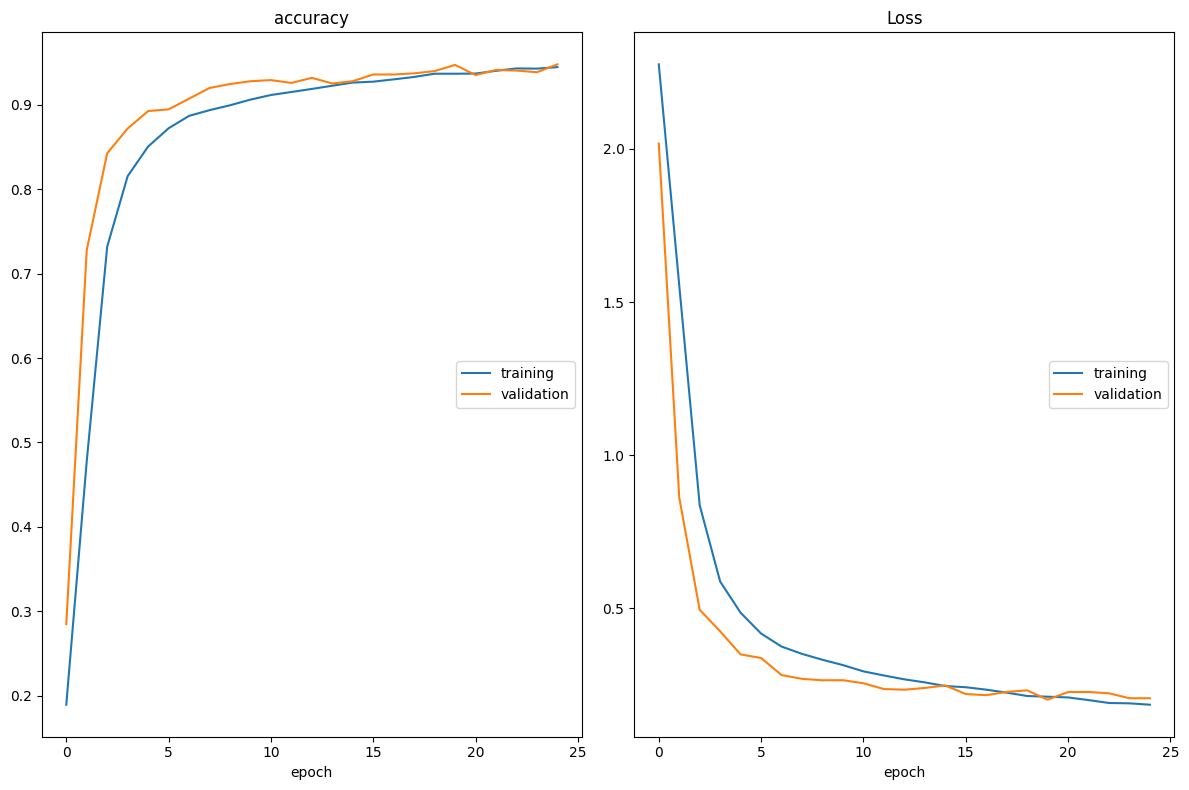

accuracy
	training         	 (min:    0.189, max:    0.945, cur:    0.945)
	validation       	 (min:    0.285, max:    0.948, cur:    0.948)
Loss
	training         	 (min:    0.186, max:    2.276, cur:    0.186)
	validation       	 (min:    0.202, max:    2.017, cur:    0.207)
95/95 [==============================] - 593s 6s/step - loss: 0.1857 - accuracy: 0.9447 - val_loss: 0.2067 - val_accuracy: 0.9480
Epoch 26/100
37/95 [==========>...................] - ETA: 6:41 - loss: 0.1715 - accuracy: 0.9478

In [14]:
model.fit(train_ds, validation_data=val_ds, epochs=100,
          callbacks=[PlotLossesKeras()], verbose=1)